# 章節 14：階層式模型

## 14.4 一點點優化

上一小節的程式碼，你可能注意到 SuiteLikelihood；我們在 11.2 小節也看過。當時，我們並不真的需要是因為 SuiteLikelihood 加總的機率是精確等於正規化的常數，並且是 Update 函數回傳的數值。

所以不要先更新 Emitter 更新其下的 Detector 組，我們可以同時做這兩件事，用 Detector.Update 作為 Emitter 的 Likelihood 的結果。
以下是更改過後的程式碼，請注意 Emitter.Likelihood 方法的差異：

In [1]:
import thinkbayes as tb
import numpy as np
import matplotlib.pyplot as plt

def plot_dist(dist, c=None):
    x, y = zip(*sorted(dist.Items()))
    plt.plot(x, y, c=c)

class Detector(tb.Suite):
    
    def __init__(self, r, f, high=500, step=1):
        
        # r 表示平均發射頻率
        # high：最高可能的粒子數
        # step：發射量的間距
        
        # n 服從 Poisson 分佈
        pmf = tb.MakePoissonPmf(r, high, step=step)
        super().__init__(pmf, name=r)
        
        self.r = r
        self.f = f
    
    
    def Likelihood(self, data, hypo):
        # data: 多少顆粒被偵測到
        k = data
        
        # hypo: 假設發射出 n 顆粒子
        n = hypo
        
        # p: 偵測率
        p = self.f
        
        # 假設發出 n 顆粒子，在偵測率 p 的情況下，實際被偵測到 k 顆粒子的似然性
        return tb.EvalBinomialPmf(k, n, p)
    
    
    def SuiteLikelihood(self, data):
        total = 0
        
        for n, prob in self.Items():
            total += prob*self.Likelihood(data, n)
        
        return total
        
        

class Emitter(tb.Suite):
    
    def __init__(self, rs, f=0.1):
        # rs 是一序列的發射率 r
        
        # detectors 為一序列針對不同的 r 的 Detector 物件
        detectors = [Detector(r, f) for r in rs]
        
        # Emitter 分佈的數值是 Detectors 物件
        super().__init__(detectors)
       
    
    def Items(self):
        return [(detector.name, prob) for detector, prob in super().Items()]
    
    
    def Likelihood(self, data, hypo):
        detector = hypo
        # 這邊看到 data 的 likelihood 就是 detector 整個分佈的加權 likelihood
        # 請參考 Detector.SuiteLikelihood()
        # like = detector.SuiteLikelihood(data)
        
        # 直接更新每個 detector 的分佈，並且得到 detector 分佈的正規化常數
        like = detector.Update(data)
        return like
        
    # 將重載的 Updte 註解掉，因為用不到了
    #def Update(self, data):
    #    # 除了 Update 自己分佈的情況，也要 Update 每個子分佈
    #    super().Update(data)
    #    
    #    # Update 每個子分佈
    #    for detector in self.Values():
    #        detector.Update(data)

以上更動也可以讓 Emitter 用父類別的 Update 方法，而不需要重載。

所以這個版本更短，而且更快，因為不需要計算正規化常數 2 次

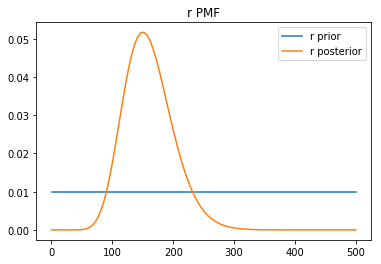

In [2]:
# 假設給定
f = 0.1
k = 15
rs = np.linspace(0.1, 500, 100) # 粒子數/秒
rate_dist = Emitter(rs)
plot_dist(rate_dist)
rate_dist.Update(k)
plot_dist(rate_dist)
plt.legend(["r prior", "r posterior"])
plt.title("r PMF")
plt.show()